In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import glob
import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [3]:
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path 
    in glob.glob(DATA_DIR + "/data/*/data.json")
])
data["rnd"] = np.random.random(len(data))

data.head(5)

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2024-03-04 09:06:00.999,2620,32065,0.00,0.001914,32069.0,{},0.721852
1,next,2024-03-04 09:06:01.057,5687,32024,0.80,0.001389,37337.0,{},0.966441
2,next,2024-03-04 09:06:01.078,7957,14080,0.80,0.001621,5540.0,{},0.289049
3,next,2024-03-04 09:06:01.092,7957,10027,0.41,0.000477,492.0,{},0.171346
4,last,2024-03-04 09:06:01.111,7957,14271,0.01,0.000207,NaN,{},0.371618


In [4]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7
positives.drop_duplicates(["user", "track"], inplace=True)

In [5]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [6]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

In [7]:
len(users), len(tracks)

(9699, 4543)

## Train LightFM

In [8]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(71075, 28155)

In [9]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [10]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [11]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
best_params = study.best_params

[I 2024-03-04 15:40:34,391] A new study created in memory with name: no-name-38e1f7ba-fc85-4939-b249-ae3305c663e1
[I 2024-03-04 15:40:46,323] Trial 0 finished with value: 0.018035734072327614 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.0001, 'max_sampled': 10, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.018035734072327614.
[I 2024-03-04 15:40:58,288] Trial 1 finished with value: 0.0074165635742247105 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 10, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.018035734072327614.
[I 2024-03-04 15:41:08,166] Trial 2 finished with value: 0.013529609888792038 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.0001, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.018035734072327614.
[I 2024-03-04 15:41:19,056] Trial 3 finished with value: 0.018327903002500534 and pa

In [13]:
best_params = {
    'loss': 'warp',
    'no_components': 50,
    'learning_rate': 0.01,
    'max_sampled': 100,
    'user_alpha': 0.0,
    'item_alpha': 0.0001
}

In [14]:
model, precisions_at = fit_model(
    epochs=300,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.018575118854641914 +/- 0.0010112762210925646
1:	0.018878525123000145 +/- 0.001022935649157718
2:	0.018934711813926697 +/- 0.0010298153440808984
3:	0.01928306557238102 +/- 0.001042260545320753
4:	0.019766267389059067 +/- 0.001057098902666654
5:	0.020024722442030907 +/- 0.0010579815042733437
6:	0.020148329436779022 +/- 0.001064058630042813
7:	0.02065400779247284 +/- 0.0010827341332846755
8:	0.021339476108551025 +/- 0.001099052162200785
9:	0.02202494628727436 +/- 0.001124481738826965
10:	0.022373301908373833 +/- 0.001136335055958571
11:	0.02284526452422142 +/- 0.0011501287343703762
12:	0.02335093915462494 +/- 0.0011615063460319551
13:	0.02394651062786579 +/- 0.0011830131714497994
14:	0.024227440357208252 +/- 0.001188527825424494
15:	0.024598270654678345 +/- 0.001204118131784601
16:	0.025070233270525932 +/- 0.001215574614886785
17:	0.025463536381721497 +/- 0.0012241875464826485
18:	0.025901786983013153 +/- 0.0012366018647933556
19:	0.026216428726911545 +/- 0.0012435280776123194
20:	0.

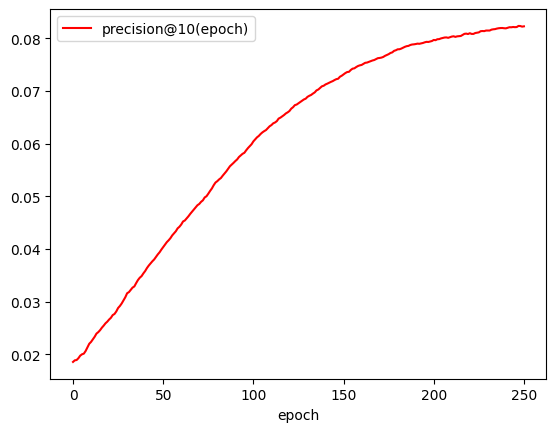

In [17]:
# TODO 1.4: Plot learning curve precision@k(epoch)
figure, ax = pl.subplots()

ax.plot(list(range(len(precisions_at))), precisions_at, "r", label="precision@10(epoch)")

ax.set_xlabel("epoch")
ax.legend()

pass

## Save track embeddings

In [18]:
BOTIFY_DATA_DIR = "/Users/n.anokhin/Projects/recsys-course/botify/data/"

In [19]:
biases, embeddings = model.get_item_representations()

In [20]:
model.item_biases *= 0.0

In [22]:
track_meta = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [23]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [24]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [25]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [27]:
with open(BOTIFY_DATA_DIR + "recommendations_lfm.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-30:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9699/9699 [00:08<00:00, 1113.78it/s]
